In [1]:
import pandas as pd
import numpy as np

from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier
from environment.fogg_behavioural_model import Patient 

In [2]:
updated_every_day = 24 

In [3]:
eight_weeks = 7 * updated_every_day * 8

In [4]:
three_weeks = 3 * updated_every_day

In [5]:
five_weeks = 5 * updated_every_day

In [6]:
runs = 10

# No interverntion

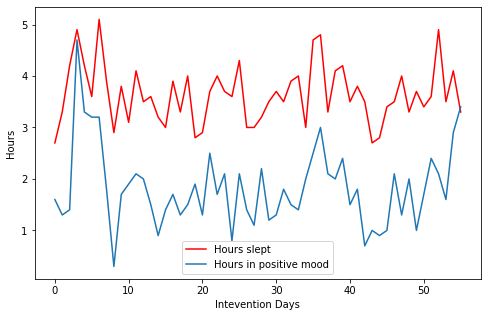

In [7]:
sleep_list = []
positive_list = []

for run in range(0, runs):
    
    env1 = Patient()
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
        
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

# Intervention

In [8]:
def intervention(method, runs, name):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    for run in range(0, runs):

        env1 = Patient()
        env1 = method(env1)

        df = pd.DataFrame()
        df['responce_ratio'] = env1.rr
        df['activity performed'] = env1.num_performed
        df['notifications'] = env1.num_notified
        df['sleep'] = env1.h_slept
        df['positive'] = env1.h_positive
        
        df.to_csv("patient1_{0}_run{1}.csv".format(name, run))
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)

    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
    ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
    ax2.plot(np.mean(not_random_list, axis=0), label='num notified')
    ax2.set_xlabel('Intervention Days')
    ax2.set_ylabel('No. notifications')
    ax1.set_ylabel('Responce ratio')
    plt.show()
    return sleep_list, positive_list, rr_random_list, not_random_list

## Heuristic

In [9]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    action = 1
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] == 3 or observation[3]==1:
            action = 0
        else:
            action = 1
            
    return env1

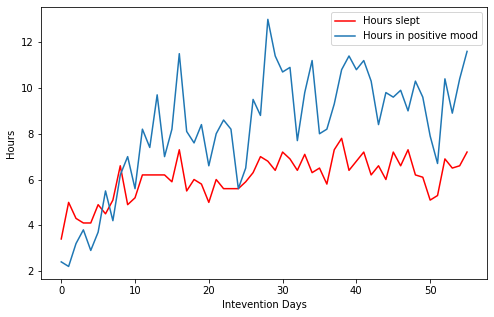

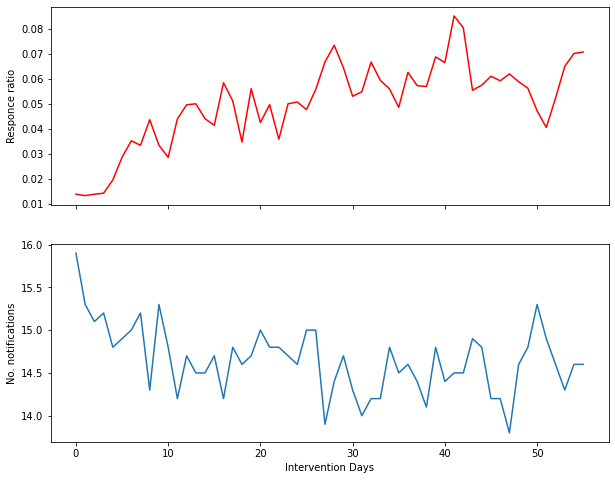

In [10]:
sleep_listh, positive_listh, rr_h_list, not_h_list = intervention(always_notify, runs, 'h')

## Random 
Randomly sample during the day skip the nights

In [33]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    action = 1
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] ==3:
            action = 0
        else:
            action = env1.action_space.sample()
            
    return env1

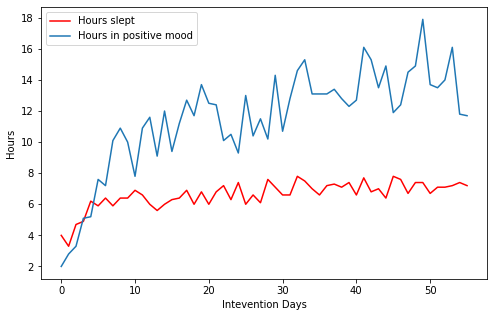

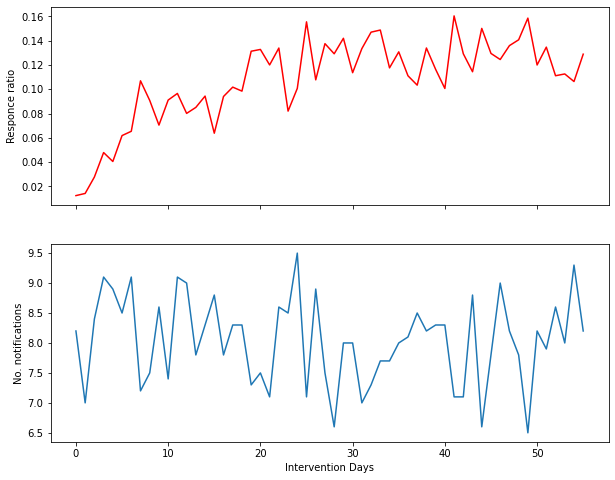

In [34]:
sleep_list, positive_list, rr_random_list, not_random_list = intervention(random_notification, runs, 'random')

## Supervised Learning

### static model

In [15]:
def supervised_until_positive_samples(env1):
    
    day = 24
    action = 1
    training_steps = 0
    
    while sum(env1.activity_performed)<7:
         #following random sampling strategy and gathering data
        env1 = random_notification(env1, intervention_legth=day)
        training_steps = training_steps + day
        if env1.env_steps==eight_weeks:
            break
    
    print("Initial training took {0} days".format(training_steps/day) )
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - training_steps
#     print(remaining_time)
#     print(env1.env_steps)
    for i in range(remaining_time):
        # applying supervised model
        observation, reward, done, info = env1.step(action)
        action = clf.predict(np.array([observation]))[0]
        
    return env1


Initial training took 9.0 days
Initial training took 56.0 days
Initial training took 16.0 days
Initial training took 26.0 days
Initial training took 18.0 days
Initial training took 17.0 days
Initial training took 35.0 days
Initial training took 47.0 days
Initial training took 56.0 days
Initial training took 56.0 days


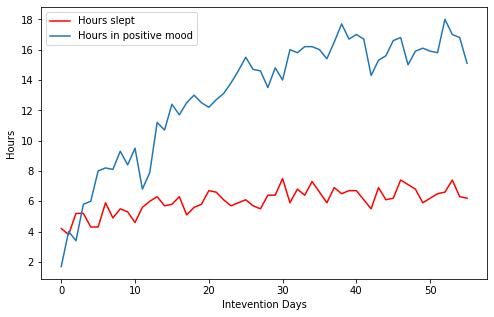

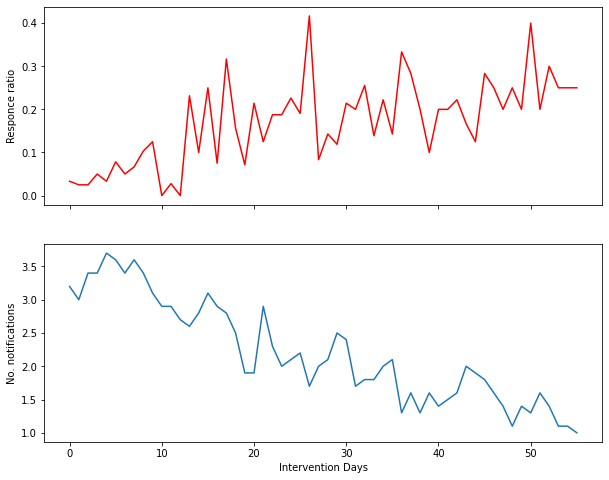

In [16]:
sleep_list_rf, positive_list_rf, rr_rf_list, not_rf_list = intervention(supervised_until_positive_samples, runs, 'static_sup')

In [31]:
def supervised_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = always_notify(env1, intervention_legth=three_weeks)
#     env1 = random_notification(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    print(sum(env1.activity_performed))
    observation = env1._get_current_state()
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        
        
    return env1

26
0
0
0
17
6
15
0
0
3


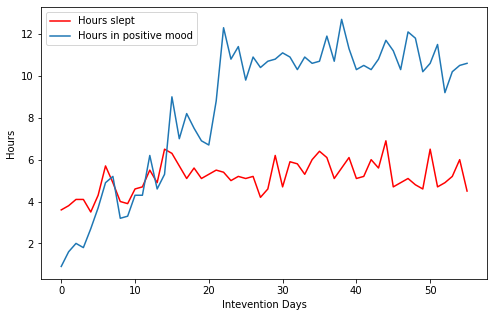

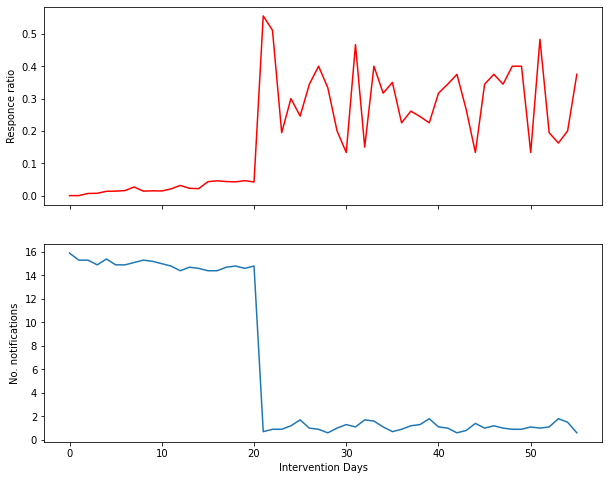

In [32]:
sleep_list_rf3, positive_list_rf3, rr_rf3_list, not_rf3_list = intervention(supervised_after_three_weeks, runs, 'static_sup3')

### adaptive model 

In [19]:
def supervised_adaptive(env1):
    
    day = 24
    action = 1
    training_steps = 0
    
    while sum(env1.activity_performed)<7:
         #following random sampling strategy and gathering data
        env1 = random_notification(env1, intervention_legth=day)
        training_steps = training_steps + day
        if env1.env_steps==eight_weeks:
            break
    
    print("Initial training took {0} days".format(training_steps/day) )
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - training_steps
    print(sum(env1.activity_performed))
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        observation, reward, done, info = env1.step(action)
        action = clf.predict(np.array([observation]))[0]
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.activity_performed)
            samples = len(env1.observation_list)
#             print(env1.activity_performed)
    return env1

Initial training took 56.0 days
0
Initial training took 56.0 days
3
Initial training took 19.0 days
7
Initial training took 56.0 days
0
Initial training took 30.0 days
7
Initial training took 56.0 days
0
Initial training took 56.0 days
0
Initial training took 56.0 days
0
Initial training took 10.0 days
7
Initial training took 50.0 days
7


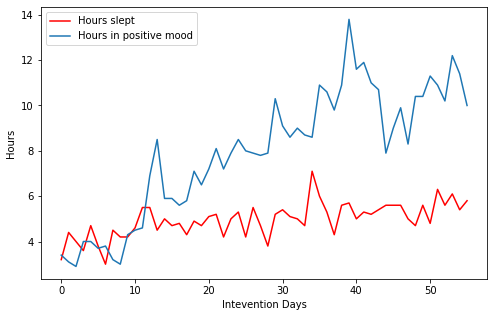

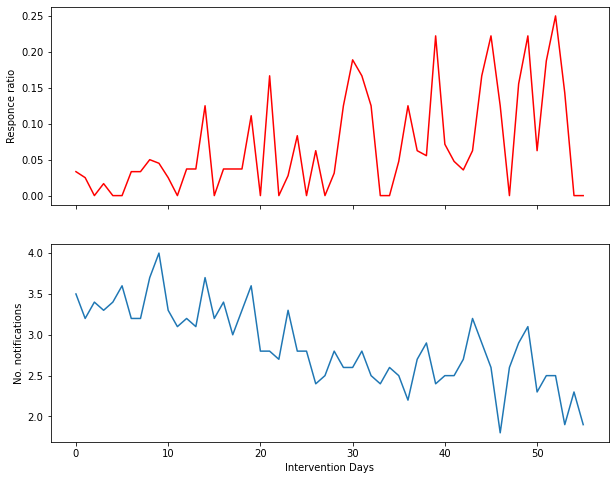

In [20]:
sleep_list_rfa, positive_list_rfa, rr_rfa_list, not_rfa_list = intervention(supervised_adaptive, runs, 'adaptive_sup')

In [21]:
def supervised_adaptive_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = always_notify(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    print(sum(env1.activity_performed))
    observation = env1._get_current_state()
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.activity_performed)
            samples = len(env1.observation_list)
            
        
    return env1

0
0
0
17
0
5
22
0
0
8


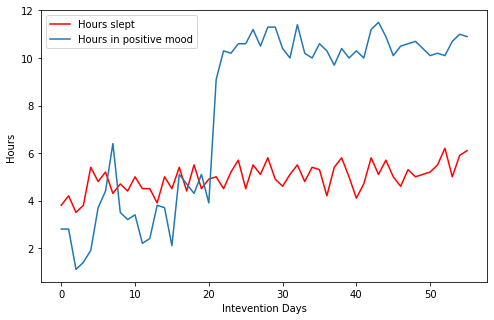

<ipython-input-8-567ef8bc0f9b>:33: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')


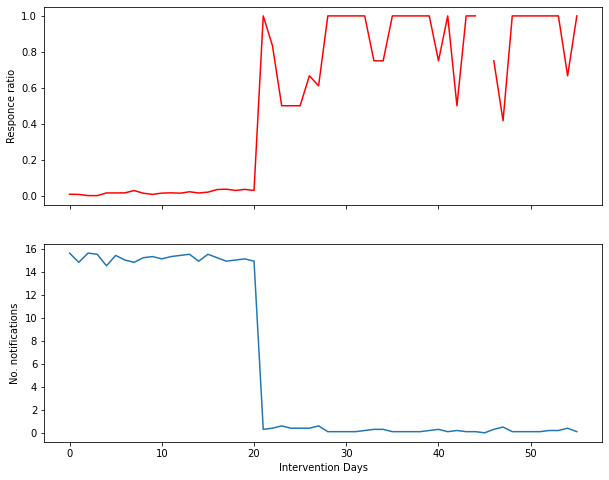

In [22]:
sleep_list_rf3a, positive_list_rf3a, rr_rf3a_list, not_rf3a_list = intervention(supervised_adaptive_after_three_weeks, runs, 'adaptive_sup3')

## Deep Q Network

In [23]:
def dqn(env1):
    week = 24*7
    model = DQN("MlpPolicy", env1, verbose=0, learning_starts=week)
    model.learn(total_timesteps=eight_weeks)
    model.save("patient1_dqn_run{0}".format(run))
    return env1

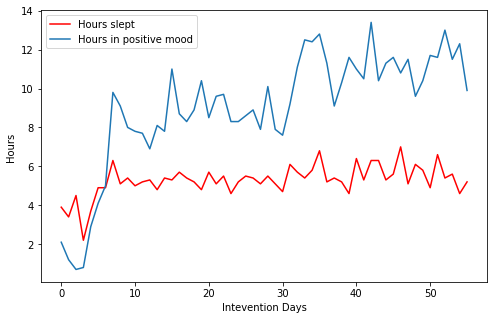

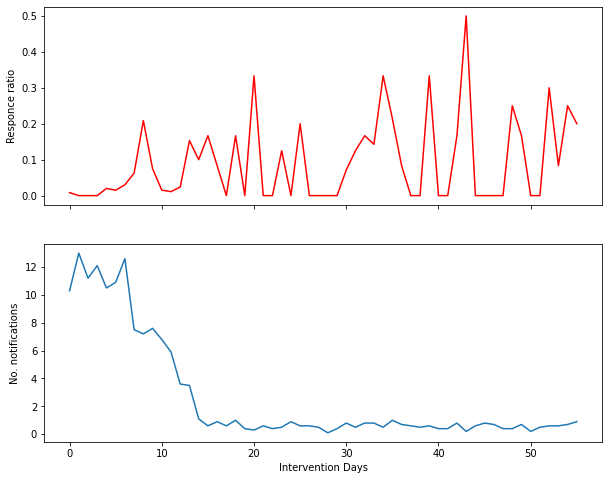

In [24]:
sleep_list_dqn, positive_list_dqn, rr_dqn_list, not_dqn_list = intervention(dqn, runs, 'dqn_week')

## Proximal Policy Optimisation

In [25]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    model.save("patient1_ppo_run{0}".format(run))

    return env1

C:\Users\Aneta\anaconda3\envs\rl\lib\site-packages\stable_baselines3\ppo\ppo.py:131: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 24`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 24
We recommend using a `batch_size` that is a multiple of `n_steps * n_envs`.
Info: (n_steps=24 and n_envs=1)
  warnings.warn(


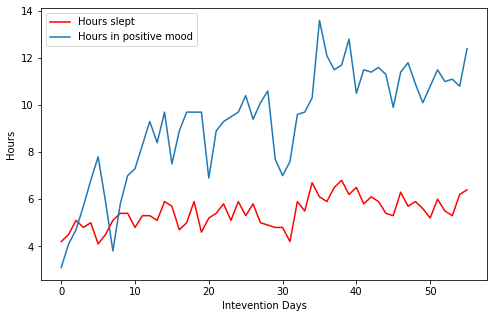

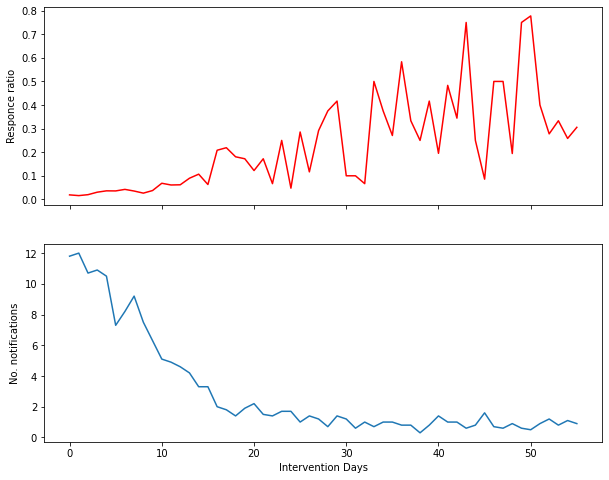

In [26]:
sleep_list_ppo, positive_list_ppo, rr_ppo_list, not_ppo_list = intervention(ppo, runs, 'ppo')

## Advantage Actor Critic

In [27]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    model.save("patient1_a2c_run{0}".format(run))
    return env1

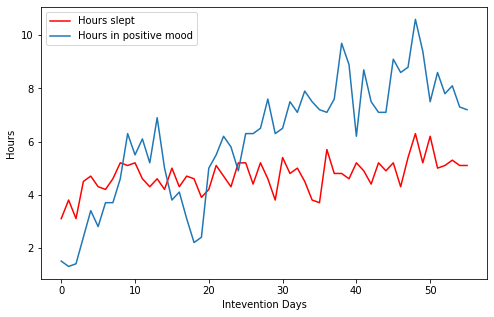

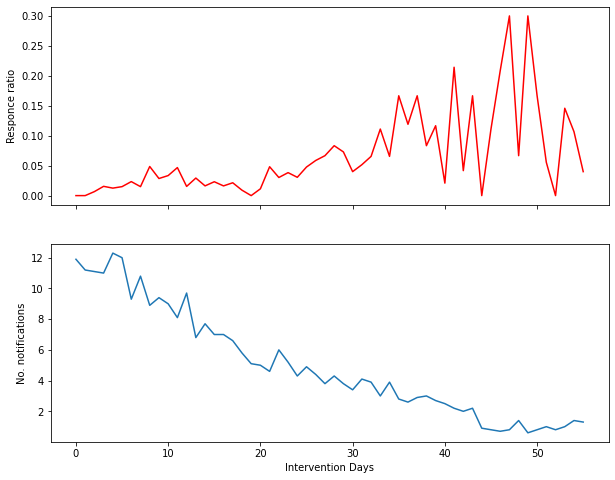

In [28]:
sleep_list_a2c, positive_list_a2c, rr_a2c_list, not_a2c_list = intervention(a2c, runs, 'a2c')

<ipython-input-35-f6528fc334ce>:4: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')


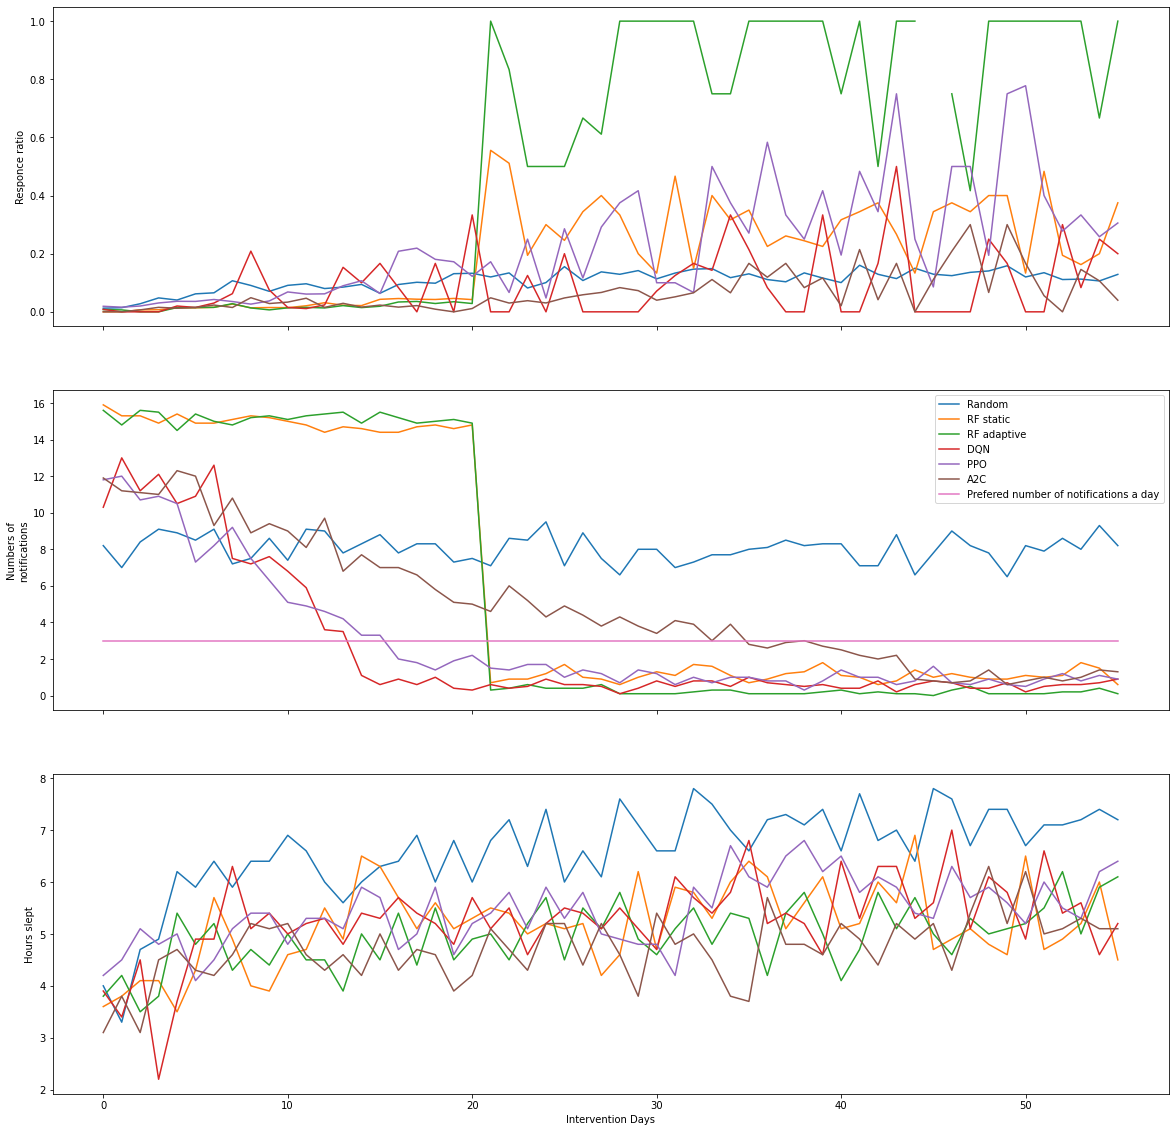

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20,20))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')

ax2.plot(np.mean(not_random_list, axis=0), label='Random')
ax2.plot(np.mean(not_rf3_list, axis=0), label='RF static')
ax2.plot(np.mean(not_rf3a_list, axis=0), label='RF adaptive')
ax2.plot(np.mean(not_dqn_list, axis=0), label='DQN')
ax2.plot(np.mean(not_ppo_list, axis=0), label='PPO')
ax2.plot(np.mean(not_a2c_list, axis=0), label='A2C')
ax2.plot(np.ones(len(np.mean(not_a2c_list, axis=0))) +2, label ='Prefered number of notifications a day')

ax3.plot(np.mean(sleep_list, axis=0), label='Random')
ax3.plot(np.mean(sleep_list_rf3, axis=0), label='RF static')
ax3.plot(np.mean(sleep_list_rf3a, axis=0), label='RF adaptive')
ax3.plot(np.mean(sleep_list_dqn, axis=0), label='DQN')
ax3.plot(np.mean(sleep_list_ppo, axis=0), label='PPO')
ax3.plot(np.mean(sleep_list_a2c, axis=0), label='A2C')
ax3.set_xlabel('Intervention Days')
ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)))
ax1.set_ylabel('\n'.join(wrap('Responce ratio', 20)) )
ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
ax2.legend()
plt.show()